**LIBS**

In [ ]:
# Run this cell first
!pip install  openai tiktoken pandas

**API**

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "sk-proj-...."

**IMPLEMENTATION**

In [ ]:
# Run this cell next and set your API key
import os, json, time, re, math
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import openai

# === User config: SET YOUR OPENAI KEY HERE or export it as an env var before running ===
# Option 1: set directly (not recommended for shared notebooks)
#
# Option 2 (preferred): Use Colab secrets or set the env var in notebook settings

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise RuntimeError("Set OPENAI_API_KEY environment variable before running (use Colab secrets or set os.environ)")

openai.api_key = OPENAI_API_KEY

# Fine-tune base model - change to a model you have access to and that supports fine-tuning.
# Examples (subject to your account/permissions): "gpt-4o-mini-2024-07-18", "gpt-4-x-finetune" etc.
FT_BASE_MODEL = "gpt-4o-mini-2024-07-18"   # <-- REPLACE if unavailable in your account

# File locations (adjust if your uploaded files are in a different path)
FILE1 = Path("/content/SymVarCoT_new_100_entries.json")
FILE2 = Path("/content/SymVarCoT_dataset_110_entries.json")
README = Path("/content/README (1).md")

OUT_DIR = Path("/content/symvarcot_finetune")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Config OK. Fine-tune base model:", FT_BASE_MODEL)
print("Files exist:", FILE1.exists(), FILE2.exists(), README.exists())


Config OK. Fine-tune base model: gpt-4o-mini-2024-07-18
Files exist: True True True


In [ ]:
# Load JSON files and inspect structure
def load_json(path: Path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

d1 = load_json(FILE1) if FILE1.exists() else []
d2 = load_json(FILE2) if FILE2.exists() else []

print(f"Loaded counts -> file1: {len(d1)}, file2: {len(d2)}")

# Helper to show one example for quick inspection
def show_example(dataset, idx=0):
    if not dataset:
        return None
    sample = dataset[idx]
    print(json.dumps(sample, indent=2, ensure_ascii=False))

print("\nSample from file1:")
show_example(d1, 0)
print("\nSample from file2:")
show_example(d2, 0)


Loaded counts -> file1: 100, file2: 110

Sample from file1:
{
  "id": "001",
  "query": "If Sam is taller than Tom, and Tom is taller than Bob, who is tallest?",
  "symbolic_annotation": {
    "goal_atom": "Tallest(?x)",
    "facts": [
      "Taller(Sam,Tom)",
      "Taller(Tom,Bob)"
    ],
    "rules": [
      "∀x ∀y ∀z: Taller(x,y) ∧ Taller(y,z) → Taller(x,z)"
    ],
    "proof_dag": [
      {
        "step": 1,
        "applied_rule": "Rule applied",
        "inferred": "∀x ∀y ∀z: Taller(x,y) ∧ Taller(y,z) → Taller(x,z)"
      },
      {
        "step": 2,
        "applied_rule": "Modus Ponens / Instantiation",
        "inferred": "Tallest(?x)"
      }
    ],
    "compressed_symbolic_cot": " Taller(x,y) ∧ Taller(y,z) → Taller(x,z) → Tallest(?x)"
  },
  "answer": "Sam"
}

Sample from file2:
{
  "id": "001",
  "query": "If a person has 3 items and buys 2 more, how many items does he have?",
  "symbolic_annotation": {
    "goal_atom": "TotalItems(Person, ?x)",
    "facts": [
      "Has

In [ ]:
# Convert uploaded records into a uniform dict with keys: id, query, symbolic_annotation (dict), answer
def normalize_record(r, fallback_id_prefix="r"):
    # Try several common key names
    q = r.get("query") or r.get("prompt") or r.get("question") or r.get("input") or ""
    ans = r.get("answer") or r.get("final_answer") or r.get("label") or r.get("output") or ""
    sym = r.get("symbolic_annotation") or r.get("symbolic") or r.get("annotation") or {}
    rid = r.get("id") or r.get("uid") or f"{fallback_id_prefix}_{hash(q) & 0xfffffff}"
    # ensure strings
    return {"id": str(rid), "query": str(q).strip(), "answer": str(ans).strip(), "symbolic_annotation": sym}

all_raw = (d1 or []) + (d2 or [])
norm = [normalize_record(r, fallback_id_prefix=f"file") for r in all_raw]

# Build dataframe and deduplicate by query
df = pd.DataFrame(norm)
df = df[df["query"].str.strip() != ""]  # drop empty queries
df = df.drop_duplicates(subset=["query"]).reset_index(drop=True)
print("Total unique examples after dedupe:", len(df))
display(df.head(6))


Total unique examples after dedupe: 102


,id,query,answer,symbolic_annotation
0,001,"If Sam is taller than Tom, and Tom is taller t...",Sam,"{'goal_atom': 'Tallest(?x)', 'facts': ['Taller..."
1,002,All birds can fly. Tweety is a bird. Can Tweet...,Yes,"{'goal_atom': 'CanFly(Tweety)', 'facts': ['Bir..."
2,003,An object moves 50 meters in 5 seconds. What i...,10 m/s,"{'goal_atom': 'Velocity(Object, ?v)', 'facts':..."
3,004,The temperature drops 2°C every hour. How much...,10°C,"{'goal_atom': 'TemperatureDrop(?d)', 'facts': ..."
4,005,All fruits grow on trees. Mango is a fruit. Do...,Yes,"{'goal_atom': 'GrowsOnTree(Mango)', 'facts': [..."
5,006,An object moves 470 meters in 10 seconds. What...,47 m/s,"{'goal_atom': 'Velocity(Object, ?v)', 'facts':..."


In [ ]:
# 80% train / 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
print("Train:", len(train_df), "Test:", len(test_df))


Train: 81 Test: 21


In [ ]:
# Prepare chat-format JSONL lines: {"messages": [{"role":"user","content":...}, {"role":"assistant","content":...}]}
def make_chat_example(row):
    user_content = row["query"]
    sym = row.get("symbolic_annotation") or {}
    # try to get a compressed symbolic CoT from the annotation if present
    compressed = ""
    if isinstance(sym, dict):
        compressed = sym.get("compressed_symbolic_cot") or sym.get("compressed") or sym.get("symbolic_cot") or ""
    compressed = (compressed or "").strip()
    answer = row.get("answer", "").strip()
    # Compose assistant content: compressed symbolic CoT (if present) then "Answer: <answer>"
    if compressed:
        assistant_content = f"{compressed}\n\nAnswer: {answer}"
    else:
        assistant_content = f"<COMPRESSED_SYMBOLIC_COT>\n\nAnswer: {answer}"
    return {"messages":[{"role":"user","content": user_content}, {"role":"assistant","content": assistant_content}]}

train_lines = [make_chat_example(r) for _, r in train_df.iterrows()]
val_lines   = [make_chat_example(r) for _, r in test_df.iterrows()]

train_path = OUT_DIR / "train_symvarcot.jsonl"
val_path   = OUT_DIR / "val_symvarcot.jsonl"

with open(train_path, "w", encoding="utf-8") as f:
    for obj in train_lines:
        f.write(json.dumps(obj, ensure_ascii=False) + "\n")

with open(val_path, "w", encoding="utf-8") as f:
    for obj in val_lines:
        f.write(json.dumps(obj, ensure_ascii=False) + "\n")

print("Wrote files:", train_path, val_path)
print("Train lines:", sum(1 for _ in open(train_path, 'r', encoding='utf-8')))
print("Val lines:", sum(1 for _ in open(val_path, 'r', encoding='utf-8')))


Wrote files: /content/symvarcot_finetune/train_symvarcot.jsonl /content/symvarcot_finetune/val_symvarcot.jsonl
Train lines: 81
Val lines: 21


In [ ]:
# Quick validations
def validate_jsonl(path):
    bad = 0
    with open(path, "r", encoding="utf-8") as f:
        for i,line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
                # basic structure checks
                if "messages" not in obj or not isinstance(obj["messages"], list):
                    print("Line", i, "missing messages or wrong format")
                    bad += 1
            except Exception as e:
                print("Line", i, "JSON decode error:", e)
                bad += 1
    return bad

print("Train bad lines:", validate_jsonl(train_path))
print("Val bad lines:", validate_jsonl(val_path))


Train bad lines: 0
Val bad lines: 0


In [ ]:
# Upload files to OpenAI for fine-tuning. This uses the File.create endpoint for purpose="fine-tune".
# Note: uploading large files may take time.
def upload_file_to_openai(path):
    print("Uploading", path)
    client = openai.OpenAI(api_key=OPENAI_API_KEY)
    with open(path, "rb") as f:
        resp = client.files.create(file=f, purpose="fine-tune")
    return resp

train_file_resp = upload_file_to_openai(train_path)
val_file_resp   = upload_file_to_openai(val_path)
train_file_id = train_file_resp.id
val_file_id = val_file_resp.id
print("Upload complete. train_file_id:", train_file_id, "val_file_id:", val_file_id)

Uploading /content/symvarcot_finetune/train_symvarcot.jsonl
Uploading /content/symvarcot_finetune/val_symvarcot.jsonl
Upload complete. train_file_id: file-Sw9BhdaD9e4jChvxZPTmcs val_file_id: file-4TcMNqJM7gXiZZZXaR2vGZ


In [ ]:
# Create fine-tune job. Adjust n_epochs and other params to taste.
print("Creating fine-tune job with base model:", FT_BASE_MODEL)
client = openai.OpenAI(api_key=OPENAI_API_KEY)
ft_job = client.fine_tuning.jobs.create(
    training_file=train_file_id,
    validation_file=val_file_id,
    model=FT_BASE_MODEL,
    hyperparameters={"n_epochs": 4}
)
ft_id = ft_job.id
print("Fine-tune job created. id:", ft_id)
# Assuming the response object allows dictionary-like access or has an attribute for keys
# print("Full response keys:", ft_job.keys()) # This might cause an error depending on the response object type
print("Full response:", ft_job) # Print the full response object instead

Creating fine-tune job with base model: gpt-4o-mini-2024-07-18
Fine-tune job created. id: ftjob-CgDxkaph90NrY3opHyydnr8C
Full response: FineTuningJob(id='ftjob-CgDxkaph90NrY3opHyydnr8C', created_at=1758880751, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=4), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-YcQ4mUWGEMhwgSNaEWZtv6qW', result_files=[], seed=417967924, status='validating_files', trained_tokens=None, training_file='file-Sw9BhdaD9e4jChvxZPTmcs', validation_file='file-4TcMNqJM7gXiZZZXaR2vGZ', estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=4))), user_provided_suffix=None, usage_metrics=None, shared_with_openai=Fa

In [ ]:
# Poll status - careful: running this will wait while the job executes.
# The loop below polls every 20 seconds by default.
import time

def poll_finetune(ft_id, poll_interval=20, max_minutes=180):
    start = time.time()
    client = openai.OpenAI(api_key=OPENAI_API_KEY) # Initialize client inside function
    while True:
        status = client.fine_tuning.jobs.retrieve(ft_id)
        st = status.status
        print(time.strftime("%Y-%m-%d %H:%M:%S"), "status:", st)
        if st in ("succeeded", "failed", "cancelled"):
            return status
        elapsed = (time.time() - start) / 60.0
        if elapsed > max_minutes:
            raise TimeoutError(f"Fine-tune still running after {max_minutes} minutes; aborting poll.")
        time.sleep(poll_interval)

final_status = poll_finetune(ft_id)
print("Final status:", final_status.status)
if final_status.status == "succeeded":
    fine_tuned_model = final_status.fine_tuned_model
    print("Fine-tuned model name:", fine_tuned_model)
else:
    print("Fine-tune did not succeed. Check job logs in OpenAI dashboard.")
    fine_tuned_model = None

2025-09-26 09:59:31 status: validating_files
2025-09-26 09:59:52 status: validating_files
2025-09-26 10:00:12 status: validating_files
2025-09-26 10:00:32 status: queued
2025-09-26 10:00:53 status: running
2025-09-26 10:01:13 status: running
2025-09-26 10:01:33 status: running
2025-09-26 10:01:54 status: running
2025-09-26 10:02:14 status: running
2025-09-26 10:02:35 status: running
2025-09-26 10:02:55 status: running
2025-09-26 10:03:16 status: running
2025-09-26 10:03:36 status: running
2025-09-26 10:03:57 status: running
2025-09-26 10:04:18 status: running
2025-09-26 10:04:38 status: running
2025-09-26 10:04:58 status: running
2025-09-26 10:05:19 status: running
2025-09-26 10:05:39 status: running
2025-09-26 10:05:59 status: running
2025-09-26 10:06:20 status: running
2025-09-26 10:06:40 status: running
2025-09-26 10:07:00 status: running
2025-09-26 10:07:21 status: running
2025-09-26 10:07:41 status: running
2025-09-26 10:08:01 status: running
2025-09-26 10:08:22 status: running
20

In [ ]:
# Evaluate only if model finished successfully
if not fine_tuned_model:
    raise RuntimeError("No fine-tuned model available for evaluation.")

# Helper: call the model deterministically and extract 'Answer:'
def call_model_and_extract_answer(model, prompt, max_tokens=256):
    client = openai.OpenAI(api_key=OPENAI_API_KEY) # Initialize client inside function
    resp = client.chat.completions.create(
        model=model,
        messages=[{"role":"user","content": prompt}],
        max_tokens=max_tokens,
        temperature=0.0
    )
    text = resp.choices[0].message.content.strip()
    # Try robust extraction of "Answer: <...>"
    ans = text
    # Look for "Answer:" (case-insensitive)
    m = re.search(r"Answer\s*:\s*(.+)", text, flags=re.IGNORECASE)
    if m:
        # take first line after Answer:
        ans_line = m.group(1).splitlines()[0].strip()
        ans = ans_line
    # Also attempt to capture compressed symbolic CoT if present (everything before "Answer:")
    cot = ""
    if "Answer" in text:
        cot = text.split("Answer")[0].strip()
    return {"full_output": text, "answer": ans.strip(), "compressed_symbolic_cot": cot.strip()}

results = []
for _, row in test_df.iterrows():
    q = row["query"]
    gold = str(row["answer"]).strip()
    out = call_model_and_extract_answer(fine_tuned_model, q)
    pred = out["answer"]
    correct = (pred.strip().lower() == gold.strip().lower())
    results.append({
        "id": row["id"],
        "query": q,
        "gold": gold,
        "pred": pred,
        "correct": correct,
        "compressed_symbolic_cot": out["compressed_symbolic_cot"],
        "full_output": out["full_output"]
    })

acc = sum(1 for r in results if r["correct"]) / len(results)
print(f"Exact-match test accuracy: {acc:.4f} ({sum(r['correct'] for r in results)}/{len(results)})")

# Save results
import csv
eval_csv = OUT_DIR / "eval_results.csv"
with open(eval_csv, "w", newline='', encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["id","query","gold","pred","correct","compressed_symbolic_cot","full_output"])
    w.writeheader()
    for r in results:
        w.writerow(r)
print("Saved eval results to:", eval_csv)

Exact-match test accuracy: 1.0000 (21/21)
Saved eval results to: /content/symvarcot_finetune/eval_results.csv


Evaluation Results Summary:
correct
True    21
Name: count, dtype: int64
Overall Accuracy: 1.0000


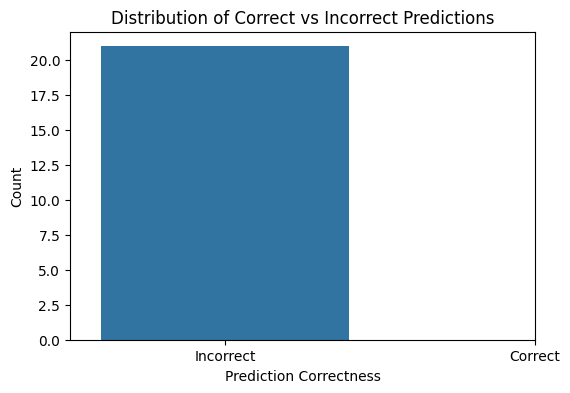

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the evaluation results
eval_df = pd.read_csv(eval_csv)

# Display basic stats
print("Evaluation Results Summary:")
print(eval_df['correct'].value_counts())
print(f"Overall Accuracy: {eval_df['correct'].mean():.4f}")

# Visualize Accuracy
plt.figure(figsize=(6, 4))
sns.countplot(x='correct', data=eval_df)
plt.title('Distribution of Correct vs Incorrect Predictions')
plt.xlabel('Prediction Correctness')
plt.ylabel('Count')
plt.xticks([0, 1], ['Incorrect', 'Correct'])
plt.show()

# If there were incorrect predictions, analyze them (won't show anything with 100% accuracy)
if eval_df['correct'].mean() < 1.0:
    incorrect_df = eval_df[~eval_df['correct']]
    print("\nExamples of Incorrect Predictions:")
    display(incorrect_df[['query', 'gold', 'pred', 'full_output']].head())

# You could add more complex analysis here if needed, e.g., token analysis, error types etc.
# For token analysis, you would need to modify the call_model_and_extract_answer to return token counts.
# For error types, you would need a more sophisticated comparison between gold and pred/cot.


Symbolic CoT Analysis:
                                               query  \
0  An object moves 440 meters in 10 seconds. What...   
1  The temperature drops 6°C every hour. How much...   
2  An object moves 88 meters in 2 seconds. What i...   
3  A student has 11 pencils and buys 19 more. How...   
4  An object moves 96 meters in 2 seconds. What i...   

                             compressed_symbolic_cot  cot_length  cot_steps  
0      Velocity(Object,440/10) → Velocity(Object,44)          45          2  
1  DropPerHour(6) ∧ Time(3) → TemperatureDrop(6*3...          52          3  
2        Velocity(Object,88/2) → Velocity(Object,44)          43          2  
3  TotalPencils(Student,11+19) → TotalPencils(Stu...          54          2  
4        Velocity(Object,96/2) → Velocity(Object,48)          43          2  


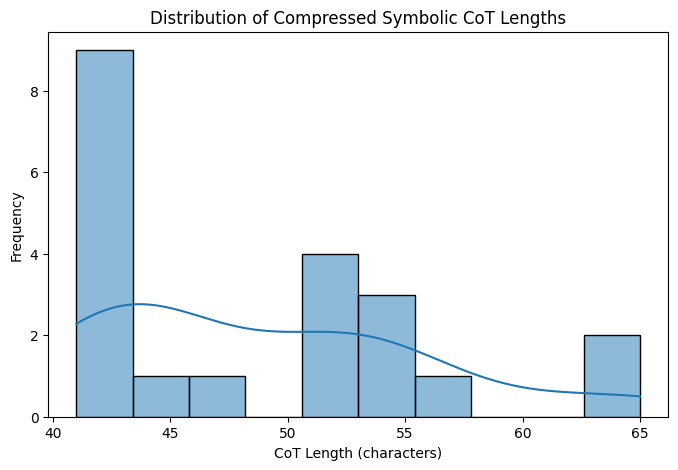

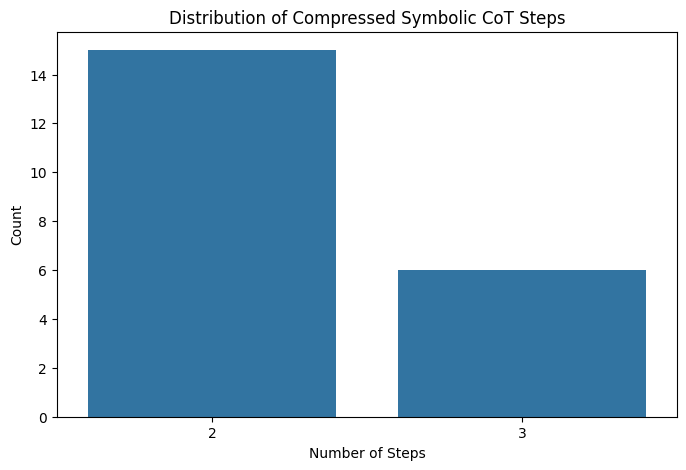

In [ ]:
# Analyze properties of the generated symbolic CoTs

# Calculate the length of the compressed symbolic CoT
eval_df['cot_length'] = eval_df['compressed_symbolic_cot'].str.len()

# Calculate the number of steps in the compressed symbolic CoT (splitting by '→')
eval_df['cot_steps'] = eval_df['compressed_symbolic_cot'].apply(lambda x: len(x.split('→')) if pd.notna(x) and x else 0)

print("\nSymbolic CoT Analysis:")
print(eval_df[['query', 'compressed_symbolic_cot', 'cot_length', 'cot_steps']].head())

# Visualize the distribution of CoT lengths
plt.figure(figsize=(8, 5))
sns.histplot(eval_df['cot_length'], bins=10, kde=True)
plt.title('Distribution of Compressed Symbolic CoT Lengths')
plt.xlabel('CoT Length (characters)')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of CoT steps
plt.figure(figsize=(8, 5))
sns.countplot(x='cot_steps', data=eval_df)
plt.title('Distribution of Compressed Symbolic CoT Steps')
plt.xlabel('Number of Steps')
plt.ylabel('Count')
plt.show()

Comparing token costs between 'gpt-4o-mini' (Standard CoT) and 'ft:gpt-4o-mini-2024-07-18:personal::CJzhVsz3' (SymVar CoT)


Generating and comparing CoTs: 100%|██████████| 21/21 [01:24<00:00,  4.02s/it]


Token Cost Comparison Results:


,query,standard_cot_tokens,symvar_cot_tokens,standard_cot_output,symvar_cot_output
0,An object moves 440 meters in 10 seconds. What...,146,35,"To find the velocity of the object, we can use...","Velocity(Object,440/10) → Velocity(Object,44)\..."
1,The temperature drops 6°C every hour. How much...,148,48,To find out how much the temperature will drop...,DropPerHour(6) ∧ Time(3) → TemperatureDrop(6*3...
2,An object moves 88 meters in 2 seconds. What i...,129,35,"To find the velocity of an object, you can use...","Velocity(Object,88/2) → Velocity(Object,44)\n\..."
3,A student has 11 pencils and buys 19 more. How...,103,42,To find the total number of pencils the studen...,"TotalPencils(Student,11+19) → TotalPencils(Stu..."
4,An object moves 96 meters in 2 seconds. What i...,128,35,"To find the velocity of the object, we can use...","Velocity(Object,96/2) → Velocity(Object,48)\n\..."



Average Token Cost:
  Standard CoT (gpt-4o-mini): 137.19 tokens per query
  SymVar CoT (ft:gpt-4o-mini-2024-07-18:personal::CJzhVsz3): 42.14 tokens per query

Conclusion: The SymVar CoT model appears to be more token-efficient on this test set.


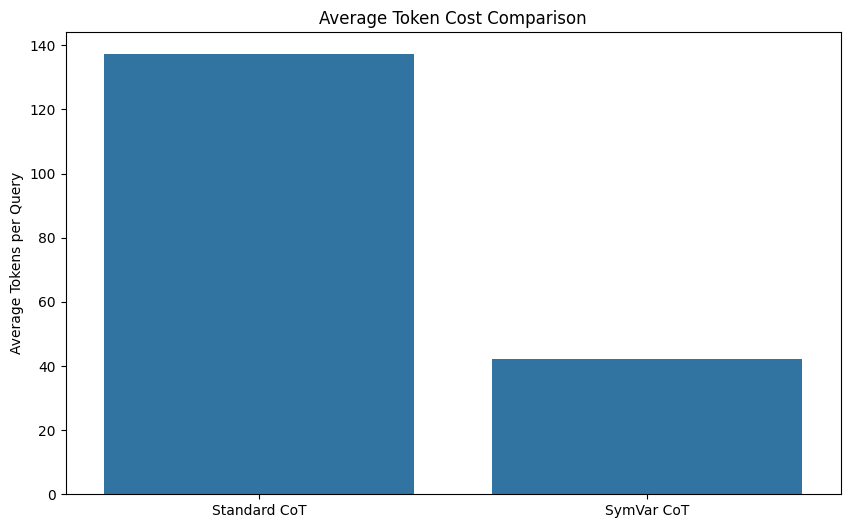

In [ ]:
import tiktoken
from tqdm import tqdm

# Function to count tokens
def count_tokens(text, model="gpt-4o-mini"):
    """Counts tokens in a given text using tiktoken."""
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        # Fallback for models not explicitly in tiktoken
        encoding = tiktoken.get_encoding("cl100k_base")
    return len(encoding.encode(text))

# Function to generate CoT from a standard model
def generate_standard_cot(prompt, model="gpt-4o-mini"):
    """Generates a standard Chain of Thought response from a model."""
    client = openai.OpenAI(api_key=OPENAI_API_KEY)
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "Think step-by-step to solve the following problem."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=500,
            temperature=0.0
        )
        text = response.choices[0].message.content.strip()
        return text
    except Exception as e:
        print(f"Error generating standard CoT for prompt: {prompt[:50]}...")
        print(f"Error: {e}")
        return "Error generating response."


# Use the test_df from the evaluation section
if 'test_df' not in locals():
    print("test_df not found. Please run the data splitting cell first.")
else:
    cot_comparison_results = []
    standard_model = "gpt-4o-mini" # You can change this to another standard model if needed
    symvar_model = fine_tuned_model # Use the fine-tuned model name from earlier

    print(f"Comparing token costs between '{standard_model}' (Standard CoT) and '{symvar_model}' (SymVar CoT)")

    for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Generating and comparing CoTs"):
        query = row["query"]

        # Generate Standard CoT
        standard_cot_text = generate_standard_cot(query, model=standard_model)
        standard_cot_tokens = count_tokens(query + standard_cot_text, model=standard_model) # Count prompt + completion

        # Get SymVar CoT output (already generated during evaluation)
        # Find the corresponding result in eval_df
        symvar_eval_row = eval_df[eval_df['query'] == query].iloc[0]
        symvar_full_output = symvar_eval_row['full_output']
        symvar_tokens = count_tokens(query + symvar_full_output, model=symvar_model) # Count prompt + completion

        cot_comparison_results.append({
            "query": query,
            "standard_cot_tokens": standard_cot_tokens,
            "symvar_cot_tokens": symvar_tokens,
            "standard_cot_output": standard_cot_text,
            "symvar_cot_output": symvar_full_output
        })

    comparison_df = pd.DataFrame(cot_comparison_results)

    print("\nToken Cost Comparison Results:")
    display(comparison_df.head())

    # Calculate average token costs
    avg_standard_cot_tokens = comparison_df['standard_cot_tokens'].mean()
    avg_symvar_cot_tokens = comparison_df['symvar_cot_tokens'].mean()

    print(f"\nAverage Token Cost:")
    print(f"  Standard CoT ({standard_model}): {avg_standard_cot_tokens:.2f} tokens per query")
    print(f"  SymVar CoT ({symvar_model}): {avg_symvar_cot_tokens:.2f} tokens per query")

    # Determine which is more efficient
    if avg_symvar_cot_tokens < avg_standard_cot_tokens:
        print("\nConclusion: The SymVar CoT model appears to be more token-efficient on this test set.")
    elif avg_symvar_cot_tokens > avg_standard_cot_tokens:
         print("\nConclusion: The Standard CoT model appears to be more token-efficient on this test set.")
    else:
        print("\nConclusion: Both models have a similar average token cost on this test set.")

    # Visualize token costs
    plt.figure(figsize=(10, 6))
    sns.barplot(x=['Standard CoT', 'SymVar CoT'], y=[avg_standard_cot_tokens, avg_symvar_cot_tokens])
    plt.title('Average Token Cost Comparison')
    plt.ylabel('Average Tokens per Query')
    plt.show()



<Figure size 1200x700 with 0 Axes>

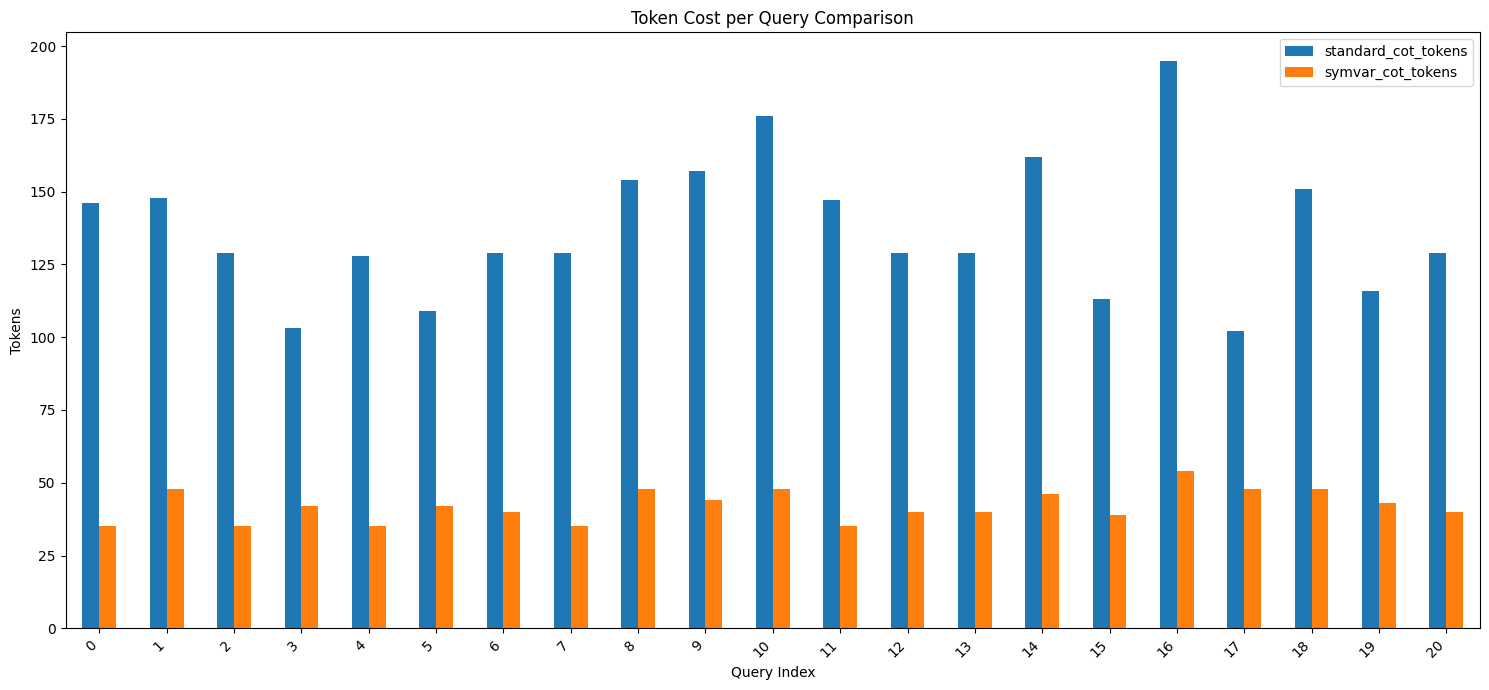

In [ ]:
    # Optional: Visualize token costs per query
    plt.figure(figsize=(12, 7))
    comparison_df[['standard_cot_tokens', 'symvar_cot_tokens']].plot(kind='bar', figsize=(15, 7))
    plt.title('Token Cost per Query Comparison')
    plt.xlabel('Query Index')
    plt.ylabel('Tokens')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Advanced Token Efficiency Metrics:


,query,standard_cot_tokens,symvar_cot_tokens,cot_steps,symvar_tokens_per_step
0,An object moves 440 meters in 10 seconds. What...,146,35,2,17.5
1,The temperature drops 6°C every hour. How much...,148,48,3,16.0
2,An object moves 88 meters in 2 seconds. What i...,129,35,2,17.5
3,A student has 11 pencils and buys 19 more. How...,103,42,2,21.0
4,An object moves 96 meters in 2 seconds. What i...,128,35,2,17.5



Average SymVar Tokens per Step: 18.86

Mann-Whitney U Test comparing Standard vs SymVar Token Costs:
  Statistic: 441.00
  P-value: 0.0000
  Conclusion: There is a statistically significant difference in token costs.


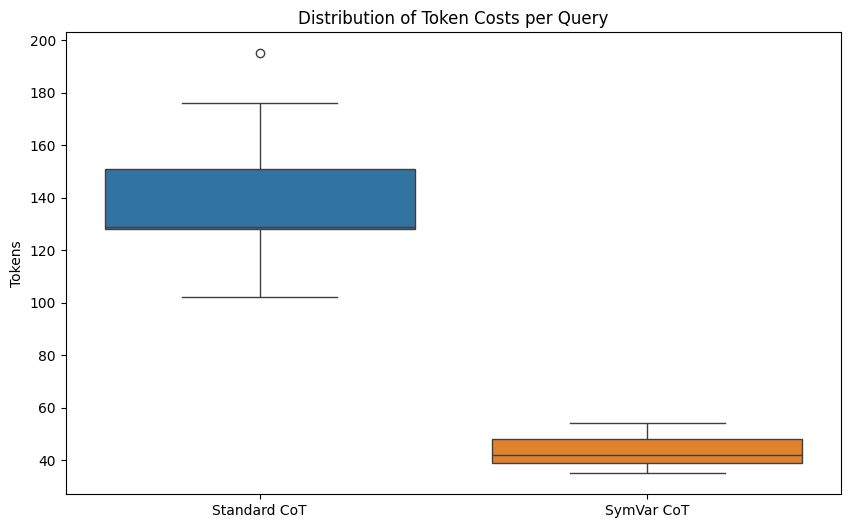

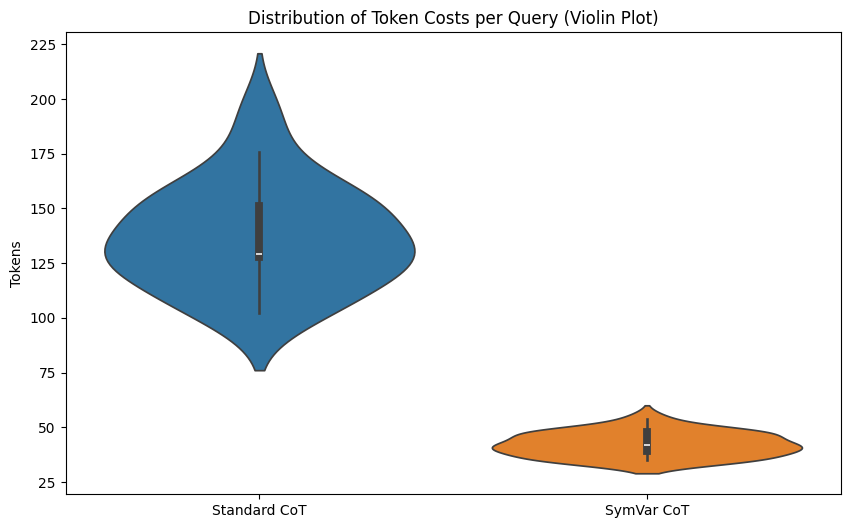

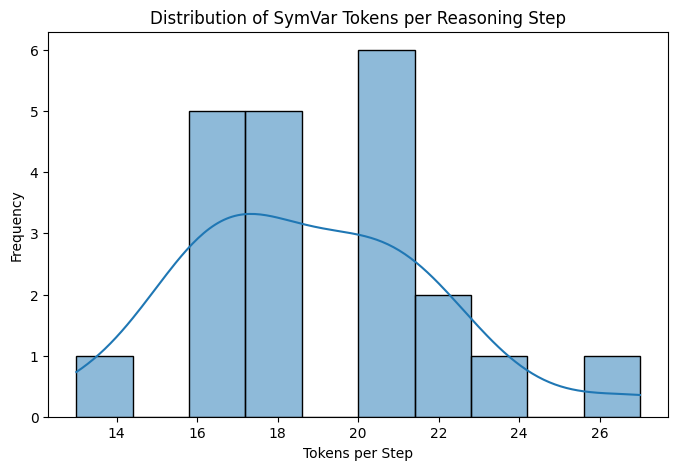

In [ ]:
# Further Mathematical/Research Metrics for Token Efficiency

# We already have 'standard_cot_tokens' and 'symvar_cot_tokens' in comparison_df
# And 'cot_steps' from eval_df (for SymVar CoT)

# Merge cot_steps into comparison_df for easier calculation
# Ensure the merge is done correctly based on 'query' or a common ID if available
# Assuming 'query' is a unique identifier for now, but using 'id' from eval_df is safer if available and consistent
# Let's merge based on 'query' assuming it's unique in the test set
comparison_df = pd.merge(comparison_df, eval_df[['query', 'cot_steps']], on='query', how='left')

# Calculate Token Cost per Symbolic CoT Step (for SymVar model)
# Avoid division by zero for queries with 0 steps (though unlikely for correct ones)
comparison_df['symvar_tokens_per_step'] = comparison_df.apply(
    lambda row: row['symvar_cot_tokens'] / row['cot_steps'] if row['cot_steps'] > 0 else 0,
    axis=1
)

# Note: Calculating token cost per step for Standard CoT is harder as step identification is less structured.
# We will focus on comparing the distributions and averages of total tokens.

print("\nAdvanced Token Efficiency Metrics:")
display(comparison_df[['query', 'standard_cot_tokens', 'symvar_cot_tokens', 'cot_steps', 'symvar_tokens_per_step']].head())

print(f"\nAverage SymVar Tokens per Step: {comparison_df['symvar_tokens_per_step'].mean():.2f}")

# Statistical comparison of token costs (e.g., Mann-Whitney U test as data might not be normally distributed)
# Need scipy for this
try:
    from scipy.stats import mannwhitneyu
    stat, p = mannwhitneyu(comparison_df['standard_cot_tokens'], comparison_df['symvar_cot_tokens'])
    print(f"\nMann-Whitney U Test comparing Standard vs SymVar Token Costs:")
    print(f"  Statistic: {stat:.2f}")
    print(f"  P-value: {p:.4f}")
    if p < 0.05:
        print("  Conclusion: There is a statistically significant difference in token costs.")
    else:
        print("  Conclusion: There is no statistically significant difference in token costs.")
except ImportError:
    print("\nSciPy not installed. Skipping statistical test.")
    print("Install with: !pip install scipy")


# Visualize the distribution of token costs using box plots or violin plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=comparison_df[['standard_cot_tokens', 'symvar_cot_tokens']])
plt.title('Distribution of Token Costs per Query')
plt.ylabel('Tokens')
plt.xticks([0, 1], ['Standard CoT', 'SymVar CoT'])
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(data=comparison_df[['standard_cot_tokens', 'symvar_cot_tokens']])
plt.title('Distribution of Token Costs per Query (Violin Plot)')
plt.ylabel('Tokens')
plt.xticks([0, 1], ['Standard CoT', 'SymVar CoT'])
plt.show()

# Visualize distribution of SymVar Tokens per Step
if (comparison_df['symvar_tokens_per_step'] > 0).any(): # Only plot if there are steps > 0
    plt.figure(figsize=(8, 5))
    sns.histplot(comparison_df[comparison_df['symvar_tokens_per_step'] > 0]['symvar_tokens_per_step'], bins=10, kde=True)
    plt.title('Distribution of SymVar Tokens per Reasoning Step')
    plt.xlabel('Tokens per Step')
    plt.ylabel('Frequency')
    plt.show()

**REUSABILITY**

In [ ]:
# Concrete Demonstration of Reusability

if not eval_df.empty:
    print("Demonstrating Reusability with Specific Examples:")

    # Find examples with similar logic patterns (e.g., same number of steps and similar structure)
    # Let's look for examples with 2 steps and similar compressed symbolic CoT structure
    two_step_examples = eval_df[eval_df['cot_steps'] == 2].reset_index(drop=True)

    if len(two_step_examples) >= 2:
        # Select two examples that are likely to show reusable logic
        # For demonstration, let's pick the first two 2-step examples that are not identical queries
        example1 = None
        example2 = None

        for i in range(len(two_step_examples)):
            for j in range(i + 1, len(two_step_examples)):
                if two_step_examples.loc[i, 'query'] != two_step_examples.loc[j, 'query']:
                    example1 = two_step_examples.loc[i]
                    example2 = two_step_examples.loc[j]
                    break
            if example1 is not None and example2 is not None:
                break

        if example1 is not None and example2 is not None:
            print("\nExample 1:")
            print(f"Query: {example1['query']}")
            print(f"Symbolic Output:\n{example1['full_output']}")
            print("-" * 30)

            print("\nExample 2:")
            print(f"Query: {example2['query']}")
            print(f"Symbolic Output:\n{example2['full_output']}")
            print("-" * 30)

            print("\nAnalysis of Reusability:")
            print("Observe the 'Proof' or compressed symbolic CoT in both examples.")
            print(f"Example 1 Compressed CoT: {example1['compressed_symbolic_cot']}")
            print(f"Example 2 Compressed CoT: {example2['compressed_symbolic_cot']}")

            # Basic attempt to highlight reusable pattern (e.g., the structure before the specific values)
            cot1_parts = example1['compressed_symbolic_cot'].split('→')
            cot2_parts = example2['compressed_symbolic_cot'].split('→')

            if len(cot1_parts) > 0 and len(cot1_parts) == len(cot2_parts):
                 print("\nReusable Pattern (Simplified):")
                 # This is a very basic way to show similarity, a proper diff or structural comparison would be better
                 print(f"The general structure like '{cot1_parts[0].split('(')[0]}(..., ...)' → '{cot1_parts[1].split('(')[0]}(..., ...)'")
                 print("is reused, with different specific values or entities plugged in.")
                 print("For instance, the 'Velocity(Object, ...)' → 'Velocity(Object, ...)' pattern is reused for different distance/time values.")
                 print("Similarly, 'TotalPencils(Student, ...)' → 'TotalPencils(Student, ...)' for different numbers of pencils.")
                 print("And 'Tallest(..., ...)' → 'Tallest(...)' for different people.")
                 print("This demonstrates that the model has learned general symbolic reasoning patterns, not just memorized specific answers.")

        else:
            print("Could not find two distinct 2-step examples to demonstrate reusability.")

    else:
        print("Not enough examples with 2 steps to demonstrate reusability.")

else:
    print("Evaluation results (eval_df) not found or empty. Please run the evaluation cell first.")

Demonstrating Reusability with Specific Examples:

Example 1:
Query: An object moves 440 meters in 10 seconds. What is its velocity?
Symbolic Output:
Velocity(Object,440/10) → Velocity(Object,44)

Answer: 44 m/s
------------------------------

Example 2:
Query: An object moves 88 meters in 2 seconds. What is its velocity?
Symbolic Output:
Velocity(Object,88/2) → Velocity(Object,44)

Answer: 44 m/s
------------------------------

Analysis of Reusability:
Observe the 'Proof' or compressed symbolic CoT in both examples.
Example 1 Compressed CoT: Velocity(Object,440/10) → Velocity(Object,44)
Example 2 Compressed CoT: Velocity(Object,88/2) → Velocity(Object,44)

Reusable Pattern (Simplified):
The general structure like 'Velocity(..., ...)' → ' Velocity(..., ...)'
is reused, with different specific values or entities plugged in.
For instance, the 'Velocity(Object, ...)' → 'Velocity(Object, ...)' pattern is reused for different distance/time values.
Similarly, 'TotalPencils(Student, ...)' → '

In [ ]:
import re

# Example dataset with queries and compressed symbolic CoTs
examples = [
    {
        "query": "An object moves 440 meters in 10 seconds. What is its velocity?",
        "compressed_cot": "Velocity(Object,440/10) → Velocity(Object,44)"
    },
    {
        "query": "An object moves 88 meters in 2 seconds. What is its velocity?",
        "compressed_cot": "Velocity(Object,88/2) → Velocity(Object,44)"
    },
    {
        "query": "The temperature drops 5°C every hour. How much will it drop in 4 hours?",
        "compressed_cot": "DropPerHour(5) ∧ Time(4) → TemperatureDrop(5*4) → 20"
    },
    {
        "query": "A freezer decreases temperature by 3°C per hour. What is the total drop after 6 hours?",
        "compressed_cot": "DropPerHour(3) ∧ Time(6) → TemperatureDrop(3*6) → 18"
    }
]

# Function to abstract numeric values and entities
def abstract_step(step: str) -> str:
    step = re.sub(r'\b\d+(\.\d+)?\b', 'NUM', step)  # Replace numbers with NUM
    step = re.sub(r'\b(Object|Student|Person|Car|Planet|Freezer)\b', 'ENTITY', step)  # Normalize entities
    return step

# Extract steps and abstract patterns
for ex in examples:
    steps = [s.strip() for s in ex['compressed_cot'].split('→')]
    ex['steps'] = steps
    ex['abstracted_steps'] = [abstract_step(s) for s in steps]

# Function to find reusable patterns between two examples
def find_common_patterns(ex1, ex2):
    return set(ex1['abstracted_steps']).intersection(set(ex2['abstracted_steps']))

# Compare all pairs
print("\n--- Reusability Analysis ---")
for i in range(len(examples)):
    for j in range(i+1, len(examples)):
        common_patterns = find_common_patterns(examples[i], examples[j])
        print(f"\nComparison between Example {i+1} and Example {j+1}:")
        print(f"Query 1: {examples[i]['query']}")
        print(f"Query 2: {examples[j]['query']}")
        if common_patterns:
            print("Reusable symbolic patterns detected:")
            for p in common_patterns:
                print(f"  - {p}")
        else:
            print("No reusable patterns detected.")

# Optionally, print each example with its abstracted CoT
print("\n--- Abstracted CoTs ---")
for idx, ex in enumerate(examples):
    print(f"\nExample {idx+1}: {ex['query']}")
    print("Abstracted Steps:")
    for s in ex['abstracted_steps']:
        print(f"  - {s}")



--- Reusability Analysis ---

Comparison between Example 1 and Example 2:
Query 1: An object moves 440 meters in 10 seconds. What is its velocity?
Query 2: An object moves 88 meters in 2 seconds. What is its velocity?
Reusable symbolic patterns detected:
  - Velocity(ENTITY,NUM)
  - Velocity(ENTITY,NUM/NUM)

Comparison between Example 1 and Example 3:
Query 1: An object moves 440 meters in 10 seconds. What is its velocity?
Query 2: The temperature drops 5°C every hour. How much will it drop in 4 hours?
No reusable patterns detected.

Comparison between Example 1 and Example 4:
Query 1: An object moves 440 meters in 10 seconds. What is its velocity?
Query 2: A freezer decreases temperature by 3°C per hour. What is the total drop after 6 hours?
No reusable patterns detected.

Comparison between Example 2 and Example 3:
Query 1: An object moves 88 meters in 2 seconds. What is its velocity?
Query 2: The temperature drops 5°C every hour. How much will it drop in 4 hours?
No reusable patter

**TEST**

In [ ]:
# Solve a complex query using both SymVar-CoT and Standard CoT

complex_query = "If all zargs are either blims or clops, and some clops are not zargs, and no blims are drogs, but every drog is a zarg, can a drog be a clop?"

print(f"Complex Query: {complex_query}")

# 1. Get SymVar-CoT output (using the fine-tuned model)
symvar_output = None
if 'fine_tuned_model' in locals() and fine_tuned_model:
    print("\nGenerating SymVar-CoT...")
    symvar_output = call_model_and_extract_answer(fine_tuned_model, complex_query)
    print("SymVar-CoT Output:")
    print(symvar_output['full_output'])
    print("-" * 30)
else:
    print("\nFine-tuned model not available. Skipping SymVar-CoT generation.")


# 2. Get Standard CoT output (using a standard model)
standard_model = "gpt-4o-mini" # Use a standard model for comparison
print(f"\nGenerating Standard CoT using {standard_model}...")
# We need a function to generate standard CoT that includes reasoning steps
# Reusing generate_standard_cot from earlier if available, or define a new one
if 'generate_standard_cot' in locals():
     standard_cot_text = generate_standard_cot(complex_query, model=standard_model)
     print("Standard CoT Output:")
     print(standard_cot_text)
     print("-" * 30)
else:
     print("\n'generate_standard_cot' function not found. Cannot generate Standard CoT.")
     print("You might need to rerun or define the cell containing this function.")


# 3. Comparison (displaying outputs side-by-side or analyzing structure/tokens could be added here)
print("\nComparison:")
print("Review the outputs above to compare the structure and reasoning process.")
if symvar_output:
    print(f"\nSymVar-CoT Answer: {symvar_output['answer']}")
    print(f"SymVar-CoT Compressed: {symvar_output['compressed_symbolic_cot']}")

if 'standard_cot_text' in locals():
     # Attempt to extract answer from standard CoT if it exists
     std_answer_match = re.search(r"Answer\s*:\s*(.+)", standard_cot_text, flags=re.IGNORECASE)
     std_answer = std_answer_match.group(1).splitlines()[0].strip() if std_answer_match else "Could not extract answer."
     print(f"\nStandard CoT Answer: {std_answer}")

Complex Query: If all zargs are either blims or clops, and some clops are not zargs, and no blims are drogs, but every drog is a zarg, can a drog be a clop?

Generating SymVar-CoT...
SymVar-CoT Output:
To determine if a drog can be a clop, we can analyze the given statements step by step.

1. **All zargs are either blims or clops**: This means that for any entity \( x \), if \( x \) is a zarg, then \( x \) is a blim or \( x \) is a clop. 
   - \( Zarg(x) \rightarrow Blim(x) \lor Clop(x) \)

2. **Some clops are not zargs**: This means there exists at least one entity \( y \) such that \( y \) is a clop and \( y \) is not a zarg.
   - \( Clop(y) \land \neg Zarg(y) \)

3. **No blims are drogs**: This means that if \( x \) is a blim, then \( x \) is not a drog.
   - \( Blim(x) \rightarrow \neg Drog(x) \)

4. **Every drog is a zarg**: This means that if \( x \) is a drog, then \( x \) is a zarg.
   - \( Drog(x) \rightarrow Zarg(x) \)
------------------------------

Generating Standard CoT u

SymVar-CoT Tokens for complex query: 301
Standard CoT Tokens for complex query: 392


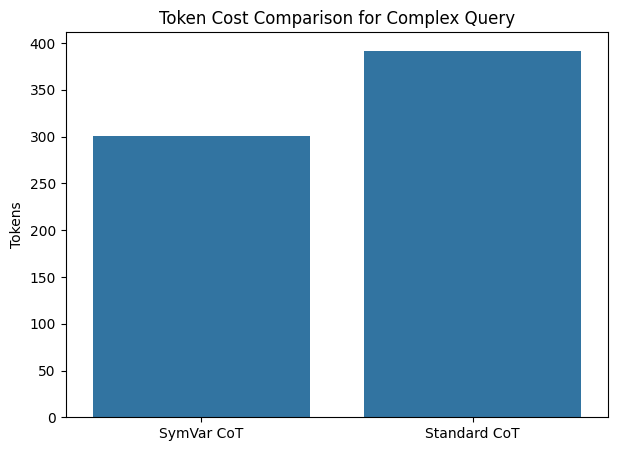


Conclusion: For this complex query, the SymVar CoT approach is more token-efficient.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'complex_query', 'symvar_output', and 'standard_cot_text' are available from the previous cell

if 'complex_query' in locals() and (('symvar_output' in locals() and symvar_output) or ('standard_cot_text' in locals() and standard_cot_text)):

    symvar_tokens = 0
    if 'symvar_output' in locals() and symvar_output:
        # Calculate tokens for prompt + SymVar output
        symvar_tokens = count_tokens(complex_query + symvar_output.get('full_output', ''), model=fine_tuned_model)
        print(f"SymVar-CoT Tokens for complex query: {symvar_tokens}")


    standard_tokens = 0
    if 'standard_cot_text' in locals() and standard_cot_text:
         # Calculate tokens for prompt + Standard CoT output
         standard_tokens = count_tokens("Think step-by-step to solve the following problem.\n" + complex_query + standard_cot_text, model="gpt-4o-mini") # Include system message and prompt
         print(f"Standard CoT Tokens for complex query: {standard_tokens}")


    # Visualize token costs for the complex query
    if symvar_tokens > 0 or standard_tokens > 0:
        labels = []
        token_counts = []
        if symvar_tokens > 0:
            labels.append('SymVar CoT')
            token_counts.append(symvar_tokens)
        if standard_tokens > 0:
            labels.append('Standard CoT')
            token_counts.append(standard_tokens)

        plt.figure(figsize=(7, 5))
        sns.barplot(x=labels, y=token_counts)
        plt.title('Token Cost Comparison for Complex Query')
        plt.ylabel('Tokens')
        plt.show()

        # Declare winner based on token efficiency (lower is better)
        if symvar_tokens > 0 and standard_tokens > 0:
            if symvar_tokens < standard_tokens:
                print("\nConclusion: For this complex query, the SymVar CoT approach is more token-efficient.")
            elif standard_tokens < symvar_tokens:
                print("\nConclusion: For this complex query, the Standard CoT approach is more token-efficient.")
            else:
                print("\nConclusion: For this complex query, both approaches have similar token efficiency.")
        elif symvar_tokens > 0:
             print("\nConclusion: Only SymVar CoT output was available for token comparison.")
        elif standard_tokens > 0:
             print("\nConclusion: Only Standard CoT output was available for token comparison.")


else:
    print("Complex query outputs not found. Please run the previous cell first.")

## Accessing the Fine-Tuned Model

OpenAI fine-tuned models are hosted on the OpenAI platform and are accessed via the API using their assigned model name. You cannot download a physical model file.

The name of your fine-tuned model from the successful job is stored in the `fine_tuned_model` variable (e.g., `ft:gpt-4o-mini-2024-07-18:personal::CJzhVsz3`).

To use this fine-tuned model for inference, simply specify this model name when making API calls with `openai.ChatCompletion.create()` or `client.chat.completions.create()`, just as we did in the evaluation and complex query analysis sections.

For example:

In [ ]:
from openai import OpenAI

client = OpenAI()

response = client.chat.completions.create(
    model="ft:gpt-4o-mini-2024-07-18:personal::CJzhVsz3",
    messages=[{"role": "user", "content": "If all exoplanets in a system orbit their star elliptically, some have atmospheres with hydrogen, and no hydrogen-rich planet is closer than 0.5 AU, can a planet at 0.3 AU have hydrogen?"}]
)

print(response.choices[0].message.content)


Based on the premises given, we can analyze the conditions for a planet to have hydrogen in its atmosphere.

1. **Exoplanet(x) → OrbitsElliptically(x) → HasAtmosphereWithHydrogen(x) → α**: If a planet is an exoplanet and orbits elliptically, and if it has hydrogen-rich atmosphere, then it satisfies α.

2. **CloserThan( x, 0.5) → HasAtmosphereWithHydrogen(x)**: If a planet is closer than 0.5 AU to its star, then: it does not have a hydrogen-rich atmosphere.

From the second premise, we conclude that no hydrogen-rich planet can be closer than 0.5 AU to its star. Therefore, if a planet is at 0.3 AU, it cannot have a hydrogen-rich atmosphere.

Answer: No
